In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 14:33:57 2023

@author: Lin
"""

import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
sys.path.append(current_path+'/../calculate_tangent/')

def simple_magnitude(freqArray):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray_circle = np.ones(binNum)
    freqArray_circle = freqArray_circle/sum(freqArray_circle*binValue)

    magnitude_max = np.max(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)
    magnitude_ave = np.average(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)

    magnitude_stan = np.sqrt(np.sum((abs(freqArray - freqArray_circle)/np.average(freqArray_circle) - magnitude_ave)**2)/binNum)

    return magnitude_ave, magnitude_stan

    # coeff_high = abs(np.cos((xCor-90)/180*np.pi))
    # coeff_low = abs(np.cos((xCor)/180*np.pi))
    # return np.sum(freqArray * coeff_high)/np.sum(freqArray * coeff_low)

def find_fittingEllipse2(array): #failure
    K_mat = []
    Y_mat = []

    # Get the self-variable
    X = array[:,0]
    Y = array[:,1]

    K_mat = np.hstack([X**2, X*Y, Y**2, X, Y])
    Y_mat = np.ones_like(X)

    X_mat = np.linalg.lstsq(K_mat, Y_mat)[0].squeeze()
    # X_mat = (K_mat.T*K_mat).I * K_mat.T * Y_mat

    print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(X_mat[0], X_mat[1], X_mat[2], X_mat[3], X_mat[4]))
    print(X_mat)

    return X_mat

def find_fittingEllipse3(array): 

    import cv2
    # Fit ellipse to the points
    ellipse = cv2.fitEllipse(array)
    # print(f"aspect ratio: {ellipse[1][0]/ellipse[1][1]}")

    return ellipse

def get_poly_center(micro_matrix, step):
    # Get the center of all non-periodic grains in matrix
    num_grains = int(np.max(micro_matrix[step,:]))
    center_list = np.zeros((num_grains,2))
    sites_num_list = np.zeros(num_grains)
    ave_radius_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    table = micro_matrix[step,:,:,0]
    for i in range(num_grains):
        sites_num_list[i] = np.sum(table == i+1)

        if (sites_num_list[i] < 500) or \
           (np.max(coord_refer_i[table == i+1]) - np.min(coord_refer_i[table == i+1]) == micro_matrix.shape[1]) or \
           (np.max(coord_refer_j[table == i+1]) - np.min(coord_refer_j[table == i+1]) == micro_matrix.shape[2]): # grains on bc are ignored
          center_list[i, 0] = 0
          center_list[i, 1] = 0
          sites_num_list[i] == 0
        else:
          center_list[i, 0] = np.sum(coord_refer_i[table == i+1]) / sites_num_list[i]
          center_list[i, 1] = np.sum(coord_refer_j[table == i+1]) / sites_num_list[i]
    ave_radius_list = np.sqrt(sites_num_list / np.pi)

    return center_list, ave_radius_list

def get_poly_statistical_radius(micro_matrix, sites_list, step):
    # Get the max offset of average radius and real radius
    center_list, ave_radius_list = get_poly_center(micro_matrix, step)
    num_grains = int(np.max(micro_matrix[step,:]))

    max_radius_offset_list = np.zeros(num_grains)
    for n in range(num_grains):
        center = center_list[n]
        ave_radius = ave_radius_list[n]
        sites = sites_list[n]

        if ave_radius != 0:
          for sitei in sites:
              [i,j] = sitei
              current_radius = np.sqrt((i - center[0])**2 + (j - center[1])**2)
              radius_offset = abs(current_radius - ave_radius)
              if radius_offset > max_radius_offset_list[n]: max_radius_offset_list[n] = radius_offset

          max_radius_offset_list[n] = max_radius_offset_list[n] / ave_radius

    max_radius_offset = np.average(max_radius_offset_list[max_radius_offset_list!=0])
    area_list = np.pi*ave_radius_list*ave_radius_list
    if np.sum(area_list) == 0: max_radius_offset = 0
    else: max_radius_offset = np.sum(max_radius_offset_list * area_list) / np.sum(area_list)

    return max_radius_offset

def get_poly_statistical_ar(micro_matrix, step):
    # Get the average aspect ratio
    num_grains = int(np.max(micro_matrix[step,:]))
    sites_num_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    aspect_ratio_i = np.zeros((num_grains,2))
    aspect_ratio_j = np.zeros((num_grains,2))
    aspect_ratio = np.zeros(num_grains)
    table = micro_matrix[step,:,:,0]

    aspect_ratio_i_list = [[] for _ in range(int(num_grains))]
    aspect_ratio_j_list = [[] for _ in range(int(num_grains))]
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            grain_id = int(table[i][j]-1)
            sites_num_list[grain_id] +=1
            aspect_ratio_i_list[grain_id].append(coord_refer_i[i][j])
            aspect_ratio_j_list[grain_id].append(coord_refer_j[i][j])

    for i in range(num_grains):
        aspect_ratio_i[i, 0] = len(list(set(aspect_ratio_i_list[i])))
        aspect_ratio_j[i, 1] = len(list(set(aspect_ratio_j_list[i])))
        if aspect_ratio_j[i, 1] == 0: aspect_ratio[i] = 0
        else: aspect_ratio[i] = aspect_ratio_i[i, 0] / aspect_ratio_j[i, 1]

    # aspect_ratio = np.average(aspect_ratio[aspect_ratio!=0])
    aspect_ratio = np.sum(aspect_ratio * sites_num_list) / np.sum(sites_num_list)

    return aspect_ratio

def get_normal_vector(grain_structure_figure_one, grain_num):
    nx = grain_structure_figure_one.shape[0]
    ny = grain_structure_figure_one.shape[1]
    ng = np.max(grain_structure_figure_one)
    cores = 32
    loop_times = 5
    P0 = grain_structure_figure_one
    R = np.zeros((nx,ny,2))
    smooth_class = linear2d.linear_class(nx,ny,ng,cores,loop_times,P0,R)

    smooth_class.linear_main("inclination")
    P = smooth_class.get_P()
    # sites = smooth_class.get_gb_list(1)
    # print(len(sites))
    # for id in range(2,grain_num+1): sites += smooth_class.get_gb_list(id)
    # print(len(sites))
    sites = smooth_class.get_all_gb_list()
    sites_together = []
    for id in range(len(sites)): sites_together += sites[id]
    print("Total num of GB sites: " + str(len(sites_together)))

    return P, sites_together, sites

def get_normal_vector_slope(P, sites, step, para_name, bias=None):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray = np.zeros(binNum)
    degree = []
    for sitei in sites:
        [i,j] = sitei
        dx,dy = myInput.get_grad(P,i,j)
        degree.append(math.atan2(-dy, dx) + math.pi)
        # if dx == 0:
        #     degree.append(math.pi/2)
        # elif dy >= 0:
        #     degree.append(abs(math.atan(-dy/dx)))
        # elif dy < 0:
        #     degree.append(abs(math.atan(dy/dx)))
    for i in range(len(degree)):
        freqArray[int((degree[i]/math.pi*180-xLim[0])/binValue)] += 1
    freqArray = freqArray/sum(freqArray*binValue)

    if bias is not None:
        freqArray = freqArray + bias
        freqArray = freqArray/sum(freqArray*binValue)
    # Plot
    # plt.close()
    # fig = plt.figure(figsize=(5, 5))
    # ax = plt.gca(projection='polar')

    # ax.set_thetagrids(np.arange(0.0, 360.0, 20.0),fontsize=14)
    # ax.set_thetamin(0.0)
    # ax.set_thetamax(360.0)

    # ax.set_rgrids(np.arange(0, 0.008, 0.004))
    # ax.set_rlabel_position(0.0)  # 标签显示在0°
    # ax.set_rlim(0.0, 0.008)  # 标签范围为[0, 5000)
    # ax.set_yticklabels(['0', '0.004'],fontsize=14)

    # ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    # ax.set_axisbelow('True')
    plt.plot(np.append(xCor,xCor[0])/180*math.pi, np.append(freqArray,freqArray[0]), linewidth=2, label=para_name)

    # fitting
    fit_coeff = np.polyfit(xCor, freqArray, 1)
    return freqArray












The 0.7 data size is: (201, 2400, 2400, 1)
The 0.8 data size is: (201, 2400, 2400, 1)
The 0.90 data size is: (201, 2400, 2400, 1)
The iso data size is: (201, 2400, 2400, 1)
READING DATA DONE
Time steps Found
the processor [0, 0] start...
the processor [0, 1] start...
the processor [0, 2] start...
the processor [0, 3] start...
process[0, 0] read 0 times and max qsize 0
my core time is 1.889275
the processor [0, 4] start...
process[0, 1] read 0 times and max qsize 0
my core time is 1.837488
res_back start...
my res time is 0.061319
the processor [0, 5] start...
process[0, 2] read 0 times and max qsize 0
my core time is 1.899639
res_back start...
my res time is 0.015523
the processor [0, 6] start...
process[0, 3] read 0 times and max qsize 0
my core time is 1.839591
res_back start...
my res time is 0.013835
the processor [0, 7] start...
process[0, 4] read 0 times and max qsize 0
my core time is 1.868448
res_back start...
my res time is 0.013894
the processor [1, 0] start...
process[0, 5] 

/scratch/local/26947664/ipykernel_39404/724239850.py:88: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection='polar')


iso done
the processor [0, 0] start...
the processor [0, 1] start...
the processor [0, 2] start...
the processor [0, 3] start...
process[0, 0] read 0 times and max qsize 0
my core time is 1.806027
the processor [0, 4] start...
res_back start...
my res time is 0.050321
process[0, 1] read 0 times and max qsize 0
my core time is 1.983365
the processor [0, 5] start...
res_back start...
my res time is 0.019858
the processor [0, 6] start...
process[0, 2] read 0 times and max qsize 0
my core time is 1.996866
process[0, 3] read 0 times and max qsize 0
my core time is 1.890111
the processor [0, 7] start...
res_back start...
my res time is 0.013983
res_back start...
my res time is 0.01384
process[0, 4] read 0 times and max qsize 0
my core time is 1.893561
the processor [1, 0] start...
res_back start...
my res time is 0.013456
process[0, 5] read 0 times and max qsize 0
my core time is 1.948109
the processor [1, 1] start...
res_back start...
my res time is 0.013612
the processor [1, 2] start...
pr

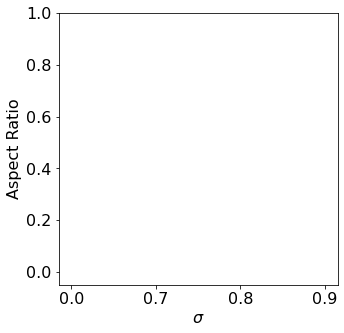

In [36]:

if __name__ == '__main__':
    # File name
    # npy_file_folder_iso = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/results/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    TJ_energy_type_070 = "0.7"
    TJ_energy_type_080 = "0.8"
    TJ_energy_type_090 = "0.9"
    # TJ_energy_type_095 = "0.95"
    # TJ_energy_type_099 = "0.99"

    energy_function = "CosMax1Mobility"
    npy_file_name_iso = "p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso_070 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_070}_J1_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso_080 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_080}_J1_refer_1_0_0_seed56689_kt0.66.npy"
    npy_file_name_aniso_090 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_090}_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_095 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_095}_J1_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso_099 = f"p_aveE_20000_{energy_function}_delta{TJ_energy_type_099}_J1_refer_1_0_0_seed56689_kt0.66.npy"


    # Initial data
    npy_file_iso = np.load(npy_file_folder + npy_file_name_iso)
    npy_file_aniso_070 = np.load(npy_file_folder + npy_file_name_aniso_070)
    npy_file_aniso_080 = np.load(npy_file_folder + npy_file_name_aniso_080)
    npy_file_aniso_090 = np.load(npy_file_folder + npy_file_name_aniso_090)
    # npy_file_aniso_095 = np.load(npy_file_folder + npy_file_name_aniso_095)
    # npy_file_aniso_099 = np.load(npy_file_folder + npy_file_name_aniso_099)
    print(f"The 0.7 data size is: {npy_file_aniso_070.shape}")
    print(f"The 0.8 data size is: {npy_file_aniso_080.shape}")
    print(f"The 0.90 data size is: {npy_file_aniso_090.shape}")
    # print(f"The 0.95 data size is: {npy_file_aniso_095.shape}")
    # print(f"The 0.99 data size is: {npy_file_aniso_099.shape}")
    print(f"The iso data size is: {npy_file_iso.shape}")
    print("READING DATA DONE")

    # Initial container
    initial_grain_num = 20000
    step_num = npy_file_iso.shape[0]
    grain_num_aniso_070 = np.zeros(step_num)
    grain_num_aniso_080 = np.zeros(step_num)
    grain_num_aniso_090 = np.zeros(step_num)
    # grain_num_aniso_095 = np.zeros(step_num)
    # grain_num_aniso_099 = np.zeros(step_num)
    grain_num_iso = np.zeros(step_num)

    # Calculate the number of grains
    for i in range(step_num):
        grain_num_aniso_070[i] = len(np.unique(npy_file_aniso_070[i,:].flatten()))
        grain_num_aniso_080[i] = len(np.unique(npy_file_aniso_080[i,:].flatten()))
        grain_num_aniso_090[i] = len(np.unique(npy_file_aniso_090[i,:].flatten()))
        # grain_num_aniso_095[i] = len(set(npy_file_aniso_095[i,:].flatten()))
        # grain_num_aniso_099[i] = len(set(npy_file_aniso_099[i,:].flatten()))
        grain_num_iso[i] = len(np.unique(npy_file_iso[i,:].flatten()))

    expected_grain_num = 1000
    special_step_distribution_070 = int(np.argmin(abs(grain_num_aniso_070 - expected_grain_num)))
    special_step_distribution_080 = int(np.argmin(abs(grain_num_aniso_080 - expected_grain_num)))
    special_step_distribution_090 = int(np.argmin(abs(grain_num_aniso_090 - expected_grain_num)))
    # special_step_distribution_095 = int(np.argmin(abs(grain_num_aniso_095 - expected_grain_num)))
    # special_step_distribution_099 = int(np.argmin(abs(grain_num_aniso_099 - expected_grain_num)))
    special_step_distribution_iso = int(np.argmin(abs(grain_num_iso - expected_grain_num)))
    print("Time steps Found")

    # Aniso - iso
    data_file_name_P = f'/well_normal_data/normal_distribution_iso_P_step{special_step_distribution_iso}.npy'
    data_file_name_sites = f'/well_normal_data/normal_distribution_iso_sites_step{special_step_distribution_iso}.npy'
    # if os.path.exists(current_path + data_file_name_P):
    #     P = np.load(current_path + data_file_name_P)
    #     sites = np.load(current_path + data_file_name_sites)
    # else:
    newplace = np.rot90(npy_file_iso[special_step_distribution_iso,:,:,:], 1, (0,1))
    P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
    # np.save(current_path + data_file_name_P, P)
    # np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_iso, "Iso")
    # For bias
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    freqArray_circle = np.ones(binNum)
    freqArray_circle = freqArray_circle/sum(freqArray_circle*binValue)
    slope_list_bias = freqArray_circle - slope_list


    # Start polar figure
    plt.close()
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca(projection='polar')

    ax.set_thetagrids(np.arange(0.0, 360.0, 45.0),fontsize=16)
    ax.set_thetamin(0.0)
    ax.set_thetamax(360.0)

    ax.set_rgrids(np.arange(0, 0.01, 0.004))
    ax.set_rlabel_position(0.0)  # 标签显示在0°
    ax.set_rlim(0.0, 0.01)  # 标签范围为[0, 5000)
    ax.set_yticklabels(['0', '4e-3', '8e-3'],fontsize=16)

    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
    ax.set_axisbelow('True')

    label_list = ["0.0", "0.7", "0.8", "0.9"]
    aniso_mag = np.zeros(len(label_list))
    aniso_mag_stand = np.zeros(len(label_list))
    aniso_rs = np.zeros(len(label_list))

    # Iso
    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_iso, "Iso",slope_list_bias)
    # aniso_mag[0], aniso_mag_stand[0] = simple_magnitude(slope_list)
    # aniso_rs[0] = get_poly_statistical_ar(npy_file_iso, special_step_distribution_iso)
    as_list = []
    for n in range(len(sites_list)):
        if len(sites_list[n]) < 10: continue
        ellipse = find_fittingEllipse3(np.array(sites_list[n]))
        as_list.append(ellipse[1][0]/ellipse[1][1])
    aniso_rs[0] = np.average(as_list)
    print("iso done")

    # Aniso - 070
    data_file_name_P = f'/well_normal_data/normal_distribution_070_P_{energy_function}_step{special_step_distribution_070}.npy'
    data_file_name_sites = f'/well_normal_data/normal_distribution_070_sites_{energy_function}_step{special_step_distribution_070}.npy'
    # if os.path.exists(current_path + data_file_name_P):
    #     P = np.load(current_path + data_file_name_P)
    #     sites = np.load(current_path + data_file_name_sites)
    # else:
    newplace = np.rot90(npy_file_aniso_070[special_step_distribution_070,:,:,:], 1, (0,1))
    P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
    # np.save(current_path + data_file_name_P, P)
    # np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_070, r"$\sigma$=0.7",slope_list_bias)
    # aniso_mag[1], aniso_mag_stand[1] = simple_magnitude(slope_list)
    # aniso_rs[1] = get_poly_statistical_ar(npy_file_aniso_070, special_step_distribution_070)
    as_list = []
    for n in range(len(sites_list)):
        if len(sites_list[n]) < 10: continue
        ellipse = find_fittingEllipse3(np.array(sites_list[n]))
        as_list.append(ellipse[1][0]/ellipse[1][1])
    aniso_rs[1] = np.average(as_list)
    print("070 done")

    # Aniso - 0.8
    data_file_name_P = f'/well_normal_data/normal_distribution_080_P_{energy_function}_step{special_step_distribution_080}.npy'
    data_file_name_sites = f'/well_normal_data/normal_distribution_080_sites_{energy_function}_step{special_step_distribution_080}.npy'
    # if os.path.exists(current_path + data_file_name_P):
    #     P = np.load(current_path + data_file_name_P)
    #     sites = np.load(current_path + data_file_name_sites)
    # else:
    newplace = np.rot90(npy_file_aniso_080[special_step_distribution_080,:,:,:], 1, (0,1))
    P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
    # np.save(current_path + data_file_name_P, P)
    # np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_080, r"$\sigma$=0.8",slope_list_bias)
    # aniso_mag[1], aniso_mag_stand[1] = simple_magnitude(slope_list)
    # aniso_rs[2] = get_poly_statistical_ar(npy_file_aniso_080, special_step_distribution_080)
    as_list = []
    for n in range(len(sites_list)):
        if len(sites_list[n]) < 10: continue
        ellipse = find_fittingEllipse3(np.array(sites_list[n]))
        as_list.append(ellipse[1][0]/ellipse[1][1])
    aniso_rs[2] = np.average(as_list)
    print("080 done")

    # Aniso - 090
    data_file_name_P = f'/well_normal_data/normal_distribution_090_P_{energy_function}_step{special_step_distribution_090}.npy'
    data_file_name_sites = f'/well_normal_data/normal_distribution_090_sites_{energy_function}_step{special_step_distribution_090}.npy'
    # if os.path.exists(current_path + data_file_name_P):
    #     P = np.load(current_path + data_file_name_P)
    #     sites = np.load(current_path + data_file_name_sites)
    # else:
    newplace = np.rot90(npy_file_aniso_090[special_step_distribution_090,:,:,:], 1, (0,1))
    P, sites, sites_list = get_normal_vector(newplace, initial_grain_num)
    # np.save(current_path + data_file_name_P, P)
    # np.save(current_path + data_file_name_sites, sites)

    slope_list = get_normal_vector_slope(P, sites, special_step_distribution_090, r"$\sigma$=0.9",slope_list_bias)
    # aniso_mag[2], aniso_mag_stand[2] = simple_magnitude(slope_list)
    # aniso_rs[3] = get_poly_statistical_ar(npy_file_aniso_090, special_step_distribution_090)
    as_list = []
    for n in range(len(sites_list)):
        if len(sites_list[n]) < 10: continue
        ellipse = find_fittingEllipse3(np.array(sites_list[n]))
        as_list.append(ellipse[1][0]/ellipse[1][1])
    aniso_rs[3] = np.average(as_list)
    print("090 done")


    plt.legend(loc=(-0.12,-0.35),fontsize=16,ncol=3)
    plt.savefig(current_path + f"/figures/Tnormal_distribution_poly_20k_after_removing_bias_{energy_function}_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    plt.close()
    fig = plt.figure(figsize=(5, 5))
    plt.plot(np.linspace(0,len(label_list)-1,len(label_list)), aniso_rs, '.-', markersize=8, linewidth=2)
    plt.xlabel(r"$\sigma$", fontsize=16)
    plt.ylabel("Aspect Ratio", fontsize=16)
    plt.xticks(np.linspace(0,len(label_list)-1,len(label_list)),label_list)
    # plt.legend(fontsize=16)
    plt.ylim([-0.05,1.0])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(current_path + f"/figures/Tanisotropic_poly_20k_aspect_ratio_{energy_function}_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')
    
    

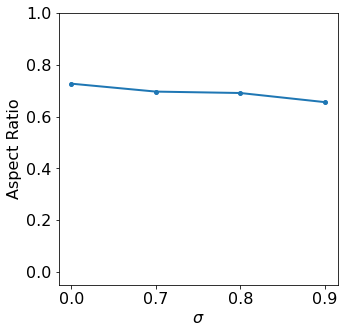

In [39]:
plt.close()
fig = plt.figure(figsize=(5, 5))
plt.plot(np.linspace(0,len(label_list)-1,len(label_list)), aniso_rs, '.-', markersize=8, linewidth=2)
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("Aspect Ratio", fontsize=16)
plt.xticks(np.linspace(0,len(label_list)-1,len(label_list)),label_list)
# plt.legend(fontsize=16)
plt.ylim([-0.05,1.0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(current_path + f"/figures/Tanisotropic_poly_20k_aspect_ratio_{energy_function}_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')
